# Citibike Stations' Inflow/Outflow Ratio
Group Members:
Cindy Y. Liu, Yuxiang Zhang

In [2]:
# Load Default settings
import pylab as pl
import pandas as pd
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Load Citibike data
df = pd.read_csv('201508-citibike-tripdata.csv')

In [4]:
# Drop unnecessary features
df = df.drop(['tripduration','starttime','stoptime'],axis=1)

In [5]:
# Store the information of stations into a csv file which includes longitude,latitude and station id
start = pd.DataFrame({'ID': df['start station id'], \
                    'Latitude': df['start station latitude'],\
                    'Longitude':df['start station longitude']})
end = pd.DataFrame({'ID': df['end station id'], \
                    'Latitude': df['end station latitude'],\
                    'Longitude':df['end station longitude']})
merged = pd.concat([start,end],axis=0)
merged = merged.drop_duplicates('ID')
merged.to_csv('station.csv')    

We use the Geopy package to [reverse geocoding](https://en.wikipedia.org/wiki/Reverse_geocoding) by converting geographic coordinates (latitude and longitude) into street addresses. Based on these, we get the corresponding borough information for each Citibike station.

In [6]:
from geopy.geocoders import Nominatim
import numpy as np
stations = pd.read_csv('station.csv')
output = np.empty(len(stations), dtype='object')
for index,station in stations.iterrows():
    geolocator = Nominatim()
    location = geolocator.reverse("%s,%s"%(str(station['Latitude']), str(station['Longitude'])),timeout=10)
    if location.raw["address"]["county"]=="New York County"or location.raw["address"]["county"]=="New York":
        output[index]="Manhattan"
    else:
        if location.raw["address"]["county"]=="Kings County":
            output[index]="Brooklyn"
        else:
            if location.raw["address"]["county"]=="Queens County":
                output[index]="Queens"
            else:
                output[index]=location.raw["address"]["county"]

Then we store the borough information of each station into a csv file named 'borough'.

In [7]:
output.tofile('borough.csv',sep='\n')

In [8]:
# Combine the station ID and its corresponding borough information into a new dataframe and export it to a new csv file
# named 'stationbyborough'
borough = output
station_by_borough = pd.DataFrame({"ID":stations["ID"],\
                                "Borough":borough})
station_by_borough.to_csv('stationbyborough.csv',sep=',')

In [9]:
# Load 'stations by borough' csv file
stations_by_borough = pd.read_csv('stationbyborough.csv')

In [10]:
# Create empty arrays for storing the number of inflow trips, outflow trips, and the ratio of inflow trips to total trips for each citibike station
in_jour, out_jour, in_out_ratio = np.zeros(len(stations_by_borough)),np.zeros(len(stations_by_borough)),np.zeros(len(stations_by_borough))

In [12]:
# Iterate through all the stations to get the total number of inflow and outflow trips of each station
for index, station in stations_by_borough.iterrows():
    start = sum(df['start station id']==station['ID'])
    end = sum(df['end station id']==station['ID'])
    in_jour[index]= start
    out_jour[index]= end
    in_out_ratio[index] = start/float(end+start)

In [14]:
# Create a new data frame which includes all the inflow and outflow information of each station
results = pd.DataFrame({'Sid':stations_by_borough['ID'],\
                      'Income':in_jour,\
                      'Outcome':out_jour,\
                      'Ratio':in_out_ratio,\
                      'Borough':stations_by_borough['Borough']})
cols = ['Sid','Income','Outcome','Ratio','Borough']
results = results[cols]
results.to_csv('result.csv')

In [15]:
# Display the summary statistics for the new data frame including all the inflow and outflow information of each station
results.describe()

,Sid,Income,Outcome,Ratio
count,421.000000,421.000000,421.000000,421.000000
mean,1020.299287,2800.579572,2800.579572,0.496943
std,1143.676593,2478.491485,2437.574067,0.041569
min,72.000000,0.000000,1.000000,0.000000
25%,317.000000,674.000000,684.000000,0.492572
50%,434.000000,2486.000000,2419.000000,0.498966
75%,2001.000000,4276.000000,4296.000000,0.504762
max,3224.000000,14498.000000,11912.000000,0.654886


In [16]:
# Calculate the number of both Manhattan and Brooklyn stations
pd.value_counts(results['Borough'].values.ravel())

Manhattan    261
Brooklyn     148
Queens        12
dtype: int64

## Statistical Analysis

In [17]:
# Create new dataframes for Manhattan and Brooklyn seperately
manhattan = results[results['Borough']=='Manhattan']
brooklyn = results[results['Borough']=='Brooklyn']

norm_m = 1
norm_b = 1

error_m = np.sqrt(manhattan['Ratio'].count())
error_b = np.sqrt(brooklyn['Ratio'].count())

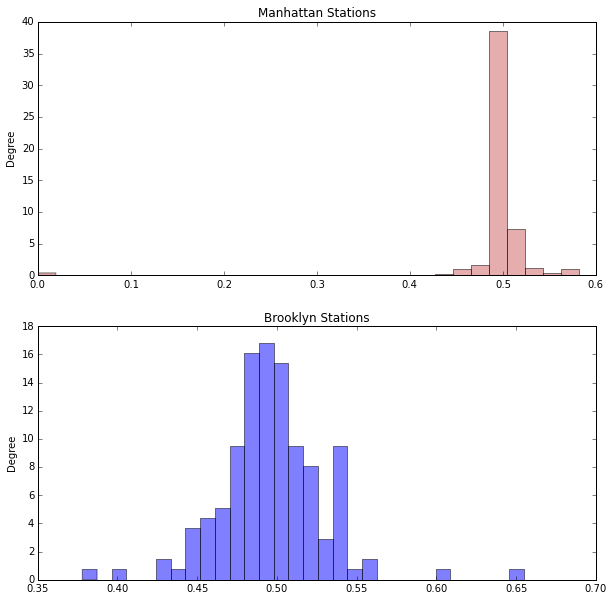

In [21]:
# Create histograms for Manhattan and Brooklyn's inflow to outflow trips ratio
from matplotlib import gridspec

fig = pl.figure(figsize(10,10))
gs = gridspec.GridSpec(2, 1)

# Plot the histogram of inflow to outflow trips ratio for Manhattan stations
ax = fig.add_subplot(gs[0,0])
manhattan['Ratio'].plot(kind="hist",yerr=[((error_m)/norm_m,(error_m)/norm_m)],\
                        bins=30,color='IndianRed', alpha=0.5,normed=1)
ax.set_title('Manhattan Stations')

# Plot the histogram of inflow to outflow trips ratio for Brooklyn stations
bx = fig.add_subplot(gs[1,0])
brooklyn['Ratio'].plot(kind="hist",yerr=[((error_b)/norm_b,(error_b)/norm_b)],\
                       bins=30, alpha=0.5,normed=1)
bx.set_title('Brooklyn Stations')

In [24]:
# Display summary statitics for Manhattan and Brooklyn's inflow to outflow trips ratio
manhattan['Ratio'].describe()

count    261.000000
mean       0.496884
std        0.046508
min        0.000000
25%        0.496087
50%        0.499340
75%        0.502453
max        0.581790
Name: Ratio, dtype: float64

In [25]:
brooklyn['Ratio'].describe()

count    148.000000
mean       0.496576
std        0.032732
min        0.377960
25%        0.480969
50%        0.495208
75%        0.512843
max        0.654886
Name: Ratio, dtype: float64

# Hypothesis: 
Manhattan's citibike stations have less inflow trips than Brooklyn.

# Z test for the mean of inflow to total trips ratios for two samples

$H_{0} : p_m-p_b>0$

$H_{\alpha}: p_m-p_b<=0$

In [38]:
# Calculate the mean and standard deviation for two samples
mean_m = np.mean(manhattan['Ratio'])
mean_b = np.mean(brooklyn['Ratio'])
std_m = np.std(manhattan['Ratio'])
std_b = np.std(brooklyn['Ratio'])
n_m = len(manhattan)
n_b = len(brooklyn)

# Create formula to calculate the standard error for the difference
SE = lambda sd1,sd2,n1,n2: np.sqrt(sd1**2/float(n1)+sd2**2/float(n2))
se = SE(std_m, std_b, n_m, n_b)

In [40]:
# Use the two sample z-test to evaluate the difference between two groups
z_1 = (mean_m - mean_b)/se
print 'z_1 = %f' % z_1

z_1 = 0.078344


In [41]:
# According to the Z-score to, compute the p-value and compare against the critical value.
p_1 = 0.5319
alpha = 0.05
def report_result(p,a):
    print 'Is the p value {0:.2f} smaller than the critical value {1:.2f}? '.format(p,a)

    print '{0}, the Null hypothesis is {1}'.format( 'Yes' if p<a  else 'No','rejected'if p<a else'not rejected')

    
report_result(p_1,alpha)

Is the p value 0.53 smaller than the critical value 0.05? 
No, the Null hypothesis is not rejected


# Z test for the proportion of trips which have more inflow trips than outflow trips (ratio > 0.5) to the total trips  in two samples.

In [42]:
P_0 = sum(manhattan['Ratio']>=0.5)/float(len(manhattan))
P_1 = sum(brooklyn['Ratio']>=0.5)/float(len(brooklyn))

n_0 = len(manhattan)
n_1 = len(brooklyn)

Nt_0 = P_0*n_0
Nt_1 = P_1*n_1
print 'P_0 = %f,P_1 = %f,n_0 = %f,n_1 = %f'%(P_0, P_1, n_0, n_1)

# Pooled Sample Proportion
psp =(P_0*n_0+P_1*n_1)/(n_1+n_0)

SE = lambda p, n1, n2: np.sqrt(psp*(1-psp)*(1/float(n1)+1/float(n2)))

se = SE(P_0,n_0,n_1)

# Z-score
zscore = lambda p0, p1, s : (p0-p1)/s
z_2 = zscore(P_1, P_0, se)
print'z_2 = %f' % z_2

P_0 = 0.425287,P_1 = 0.439189,n_0 = 261.000000,n_1 = 148.000000
z_2 = 0.272867


In [43]:
p = 1 - 0.6179
alpha = 0.05
def report_result(p,a):
    print 'Is the p value {0:.2f} smaller than the critical value {1:.2f}? '.format(p,a)
   
    print '{0}, the Null hypothesis is {1}'.format( 'Yes' if p<a  else 'No','rejected'if p<a else'not rejected')

report_result(p,alpha)

Is the p value 0.38 smaller than the critical value 0.05? 
No, the Null hypothesis is not rejected
